In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [2]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM, PyPlot, Statistics

import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");
# workspace()

In [3]:
vr_mie_source_params = CSV.read("../saftvrmie_params/saft_vr_mie_validation_data.csv", DataFrame, header=1);
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [4]:
# header = ["epoch", "species", "Mw", "m", "σ", "λ_a", "λ_r", "ϵ"]

raw_params = CSV.read("../jobs/20_more_PRE/6_ger_interlaced_strat1_lamr_25_eps_350_notrim_5e-6/params_log.csv", DataFrame, header=1)

# Set this to zero to analyze all epochs, and a natural number n for the last n epochs

last_n_rows = 0; # plot the last n epochs, set to 0 to ignore
start_row_interval = 0; # plot epoch range starting from this value, set to 0 to ignore
end_row_interval = 0; # plot epoch range starting from this value, set to 0 to ignore


┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


In [5]:
rename!(raw_params, :name => :species)
unique_values = unique(raw_params[!, :species])
num_rows = length(unique_values)

processed_data = DataFrame(
    species = fill(missing, num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    m = fill([0.0], num_rows), 
    σ = fill([0.0], num_rows),
    λ_a = fill([0.0], num_rows),
    λ_r = fill([0.0], num_rows),
    ϵ = fill([0.0], num_rows)
) ;

processed_data.species = unique_values;


In [6]:
num_epochs_plotting = 0
vmin = 0
vmax = 0

for i in unique_values
    raw_params_spec = filter(row -> isequal(row.species, i), raw_params)
    num_epochs_plotting = nrow(raw_params_spec)

    row_number_processed = findall(isequal(i), processed_data.species)
    row_number_source = findall(isequal(i), pcp_source_params.common_name)

    processed_data[row_number_processed,:isomeric_SMILES] = pcp_source_params[row_number_source,:isomeric_SMILES]
    processed_data[row_number_processed,:Mw] = [raw_params_spec[1,:Mw]]

    if start_row_interval ≠ 0 && end_row_interval ≠ 0
        processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = start_row_interval:end_row_interval]]
        num_epochs_plotting = end_row_interval - start_row_interval + 1
        vmin = start_row_interval
        vmax = end_row_interval

    elseif last_n_rows ≠ 0
        processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        vmin = num_epochs_plotting - last_n_rows + 1
        vmax = num_epochs_plotting

        num_epochs_plotting = last_n_rows

    else
        processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = 1:num_epochs_plotting]]
        vmin = 1
        vmax = num_epochs_plotting
    end
    
end

processed_data = sort(processed_data, :Mw);
# println(num_epochs_plotting)

In [44]:
test_species = "hexadecane"
# test_species = "2,2,4,4,6,8,8-Heptamethylnonane"
processed_data_test_species = filter(row -> row.species == test_species, processed_data);
processed_data_test_species;

732.5463354717438
555.5532829745193


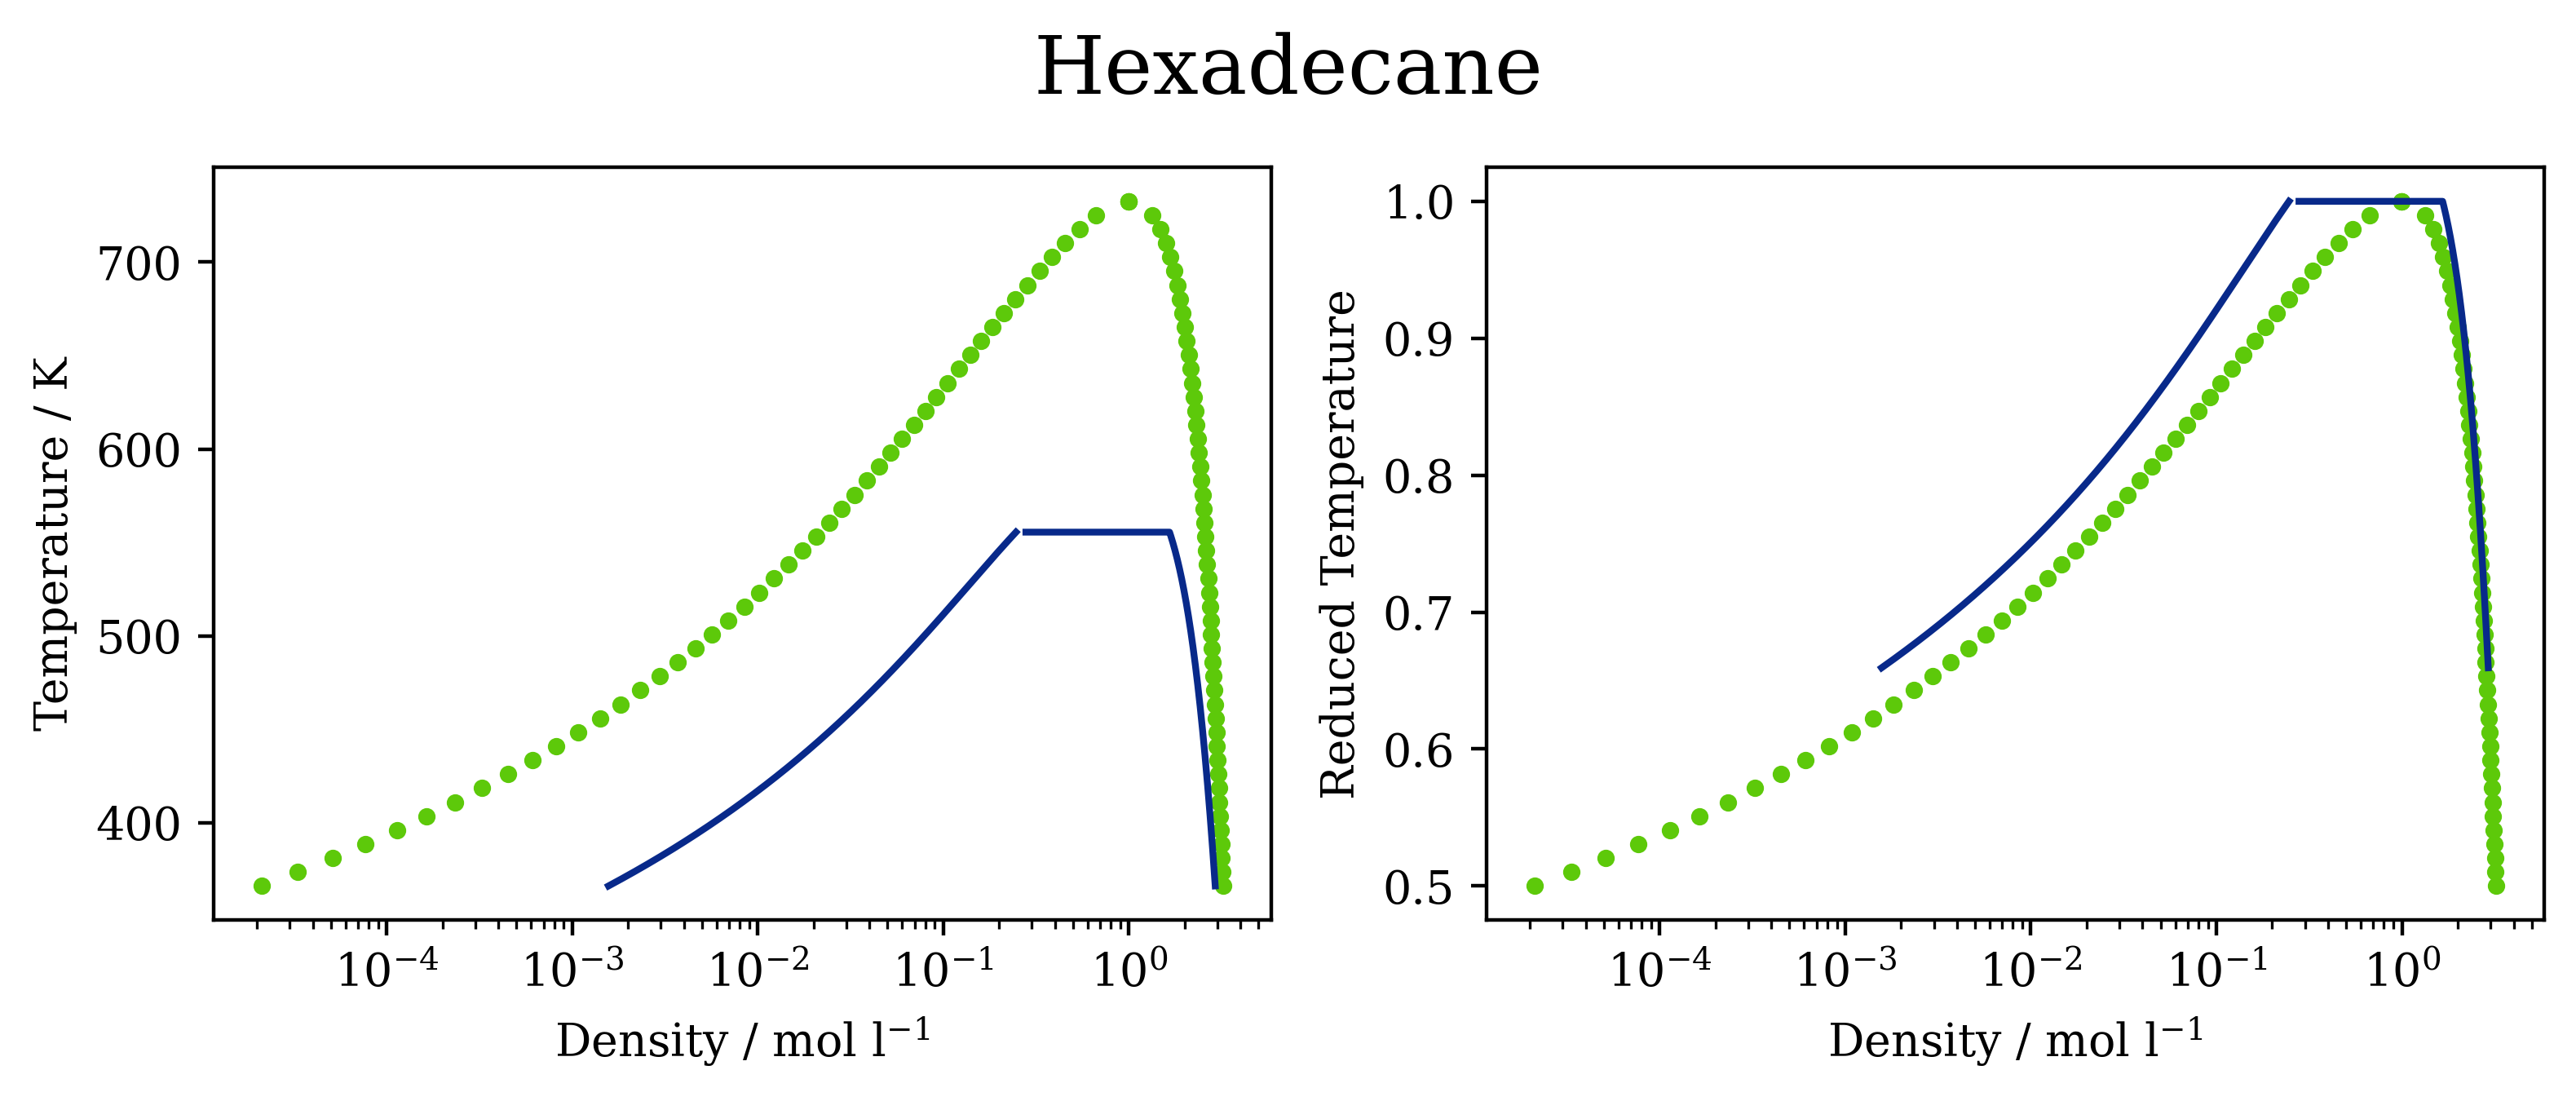

In [60]:
# Plot source pcp saft and saft-vr mie regressed parameter phase envelope (over given temperature range)

pcp_model = PPCSAFT([test_species])
Tc_pcp, pc_pcp, Vc_pcp = crit_pure(pcp_model)
T_range_pcp = collect(range(0.5 * Tc_pcp, Tc_pcp, 50))

println(Tc_pcp)

v_liq_range_pcp = []
v_vap_range_pcp = []
v_liq_range_vrmie = []
v_vap_range_vrmie = []

for T in T_range_pcp
    (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(pcp_model, T)
    push!(v_liq_range_pcp, v_liq_sat)
    push!(v_vap_range_pcp, v_vap_sat)
end

rho_pcp = 1e-3 ./ vcat(v_liq_range_pcp, Vc_pcp, v_vap_range_pcp)
T_range_pcp_plot = vcat(T_range_pcp, Tc_pcp, T_range_pcp)

Mw_test_species = processed_data_test_species[1,:Mw]
m_test_species = processed_data_test_species[1,:m][end]
σ_test_species = processed_data_test_species[1,:σ][end]
λ_a_test_species = processed_data_test_species[1,:λ_a][end]
λ_r_test_species = processed_data_test_species[1,:λ_r][end]
ϵ_test_species = processed_data_test_species[1,:ϵ][end]

vrmie_model = make_model(Mw_test_species, m_test_species, σ_test_species, λ_a_test_species, λ_r_test_species, ϵ_test_species)

Tc_vrmie, pc_vrmie, Vc_vrmie = crit_pure(vrmie_model)

println(Tc_vrmie)

T_range_vrmie = collect(range(0.5 * Tc_pcp, Tc_vrmie, 2000))

for T in T_range_vrmie
    if isempty(v_liq_range_vrmie)
        method = ChemPotVSaturation()
    else
        method = ChemPotVSaturation(vl=last(v_liq_range_vrmie), vv=last(v_vap_range_vrmie))
    end
    (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(vrmie_model, T, method)
    # (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(vrmie_model, T)
    push!(v_liq_range_vrmie, v_liq_sat)
    push!(v_vap_range_vrmie, v_vap_sat)
end

v_range_plot = vcat(v_vap_range_vrmie, Vc_vrmie, v_liq_range_vrmie)

rho_vrmie_liq = 1e-3 ./ vcat(v_liq_range_vrmie, Vc_vrmie)
rho_vrmie_vap = 1e-3 ./ vcat(v_vap_range_vrmie)

index_cutoff = argmin(abs.(T_range_vrmie .- Tc_pcp))

plt.figure(figsize=(8, 6), dpi=400)

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif")

figure_1, axes_1 = plt.subplots(1,2, figsize=(8, 3.5), dpi=400)
figure_1.suptitle("Hexadecane", fontsize=18,y=0.95)

axes_1[1].scatter(rho_pcp, T_range_pcp_plot, color="#5dc90a",s=8)

# axes_1[1].plot(rho_vrmie_liq[1:index_cutoff-1], vcat(T_range_vrmie, Tc_vrmie)[1:index_cutoff-1],color="#08298a")
# axes_1[1].plot(rho_vrmie_liq[index_cutoff:end], vcat(T_range_vrmie, Tc_vrmie)[index_cutoff:end],color="#08298a","--")

# axes_1[1].plot(rho_vrmie_vap[1:index_cutoff-1], T_range_vrmie[1:index_cutoff-1],color="#08298a")
# axes_1[1].plot(rho_vrmie_vap[index_cutoff:end], T_range_vrmie[index_cutoff:end],color="#08298a","--")

axes_1[1].plot(rho_vrmie_liq, vcat(T_range_vrmie, Tc_vrmie),color="#08298a")
axes_1[1].plot(rho_vrmie_vap, T_range_vrmie,color="#08298a")

axes_1[2].scatter(rho_pcp, T_range_pcp_plot ./Tc_pcp, color="#5dc90a",s=8)
axes_1[2].plot(rho_vrmie_liq, vcat(T_range_vrmie, Tc_vrmie) ./Tc_vrmie,color="#08298a")
axes_1[2].plot(rho_vrmie_vap, T_range_vrmie ./Tc_vrmie,color="#08298a")

axes_1[1].set_xscale("log")
# axes_1[1].set_xticks([10^-3, 10^-2, 10^-1, 10^0, 10^1, 10^2])
# axes_1[1].set_yticks(range(150,400,6))
# axes_1[1].set_ylim([150,400])
# axes_1[1].set_xlim([10^-3,10^2])
axes_1[1].set_xlabel(L"Density / mol l$\mathregular{^{-1}}$")
axes_1[1].set_ylabel("Temperature / K")

axes_1[2].set_xscale("log")
# axes_1[2].set_xticks([10^-3, 10^-2, 10^-1, 10^0, 10^1, 10^2])
# axes_1[2].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# axes_1[2].set_ylim([0.5,1.05])
# axes_1[2].set_xlim([10^-3,10^2])
axes_1[2].set_xlabel(L"Density / mol l$\mathregular{^{-1}}$")
axes_1[2].set_ylabel("Reduced Temperature")

tight_layout()

In [ ]:
# Plot source pcp saft and saft-vr mie regressed parameter phase envelope (over given temperature range)

Tc0_cache = Dict{String, Union{Nothing, Vector{BigFloat}}}()
for mol in unique_values
    Tc0_cache[mol] = nothing
end

Mw_test_species = processed_data_test_species[1,:Mw]
m_test_species = processed_data_test_species[1,:m][end]
σ_test_species = processed_data_test_species[1,:σ][end]
λ_a_test_species = processed_data_test_species[1,:λ_a][end]
λ_r_test_species = processed_data_test_species[1,:λ_r][end]
ϵ_test_species = processed_data_test_species[1,:ϵ][end]

vrmie_model = make_model(processed_data_test_species.Mw, m_predicted, σ_predicted, λ_a_predicted, λ_r_predicted, ϵ_predicted)

T̄ = Clapeyron.T_scale(vrmie_model)
Tc0 = Tc0_cache[mol]
options = Clapeyron.NEqOptions(maxiter=100_000)

if isnothing(Tc0)
    #* Must be a BigFloat to converge correctly
    Tc0 = BigFloat.(Clapeyron.x0_crit_pure(vrmie_model))
end

(Tc, pc, Vc) = crit_pure(vrmie_model, Tc0; options=options)
Tc0_cache[mol] = BigFloat.([1.1*Tc/T̄, 1.1*log10(Vc)])
(Tc, pc, Vc) = Float64.([Tc, pc, Vc])



for T in T_range
    if isempty(v_liq_range_vrmie)
        method = ChemPotVSaturation()
    else
        method = ChemPotVSaturation(vl=last(v_liq_range_vrmie), vv=last(v_vap_range_vrmie))
    end
    (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(vrmie_model, T, method)
    push!(v_liq_range_vrmie, v_liq_sat)
    push!(v_vap_range_vrmie, v_vap_sat)
end
v_range_plot = vcat(v_vap_range_vrmie, Vc, v_liq_range_vrmie)
T_range_plot = vcat(T_range, Tc, T_range)













pcp_model = PPCSAFT([test_species])
Tc_pcp, pc_pcp, Vc_pcp = crit_pure(pcp_model)
T_range_pcp = collect(range(0.5 * Tc_pcp, Tc_pcp, 50))

v_liq_range_pcp = []
v_vap_range_pcp = []
v_liq_range_vrmie = []
v_vap_range_vrmie = []

for T in T_range_pcp
    (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(pcp_model, T)
    push!(v_liq_range_pcp, v_liq_sat)
    push!(v_vap_range_pcp, v_vap_sat)
end

rho_pcp = 1e-3 ./ vcat(v_liq_range_pcp, Vc_pcp, v_vap_range_pcp)
T_range_pcp_plot = vcat(T_range_pcp, Tc_pcp, T_range_pcp)



vrmie_model = make_model(Mw_test_species, m_test_species, σ_test_species, λ_a_test_species, λ_r_test_species, ϵ_test_species)

Tc_vrmie, pc_vrmie, Vc_vrmie = crit_pure(vrmie_model)

println(Tc_vrmie)

T_range_vrmie = collect(range(0.5 * Tc_pcp, Tc_vrmie, 2000))

for T in T_range_vrmie
    if isempty(v_liq_range_vrmie)
        method = ChemPotVSaturation()
    else
        method = ChemPotVSaturation(vl=last(v_liq_range_vrmie), vv=last(v_vap_range_vrmie))
    end
    (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(vrmie_model, T, method)
    push!(v_liq_range_vrmie, v_liq_sat)
    push!(v_vap_range_vrmie, v_vap_sat)
end

v_range_plot = vcat(v_vap_range_vrmie, Vc_vrmie, v_liq_range_vrmie)

rho_vrmie_liq = 1e-3 ./ vcat(v_liq_range_vrmie, Vc_vrmie)
rho_vrmie_vap = 1e-3 ./ vcat(v_vap_range_vrmie)

index_cutoff = argmin(abs.(T_range_vrmie .- Tc_pcp))

plt.figure(figsize=(8, 6), dpi=400)

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif")

figure_1, axes_1 = plt.subplots(1,2, figsize=(8, 3.5), dpi=400)
figure_1.suptitle("2,2,3,3-Tetramethylpentane", fontsize=18,y=0.95)

axes_1[1].scatter(rho_pcp, T_range_pcp_plot, color="#5dc90a",s=8)

axes_1[1].plot(rho_vrmie_liq[1:index_cutoff-1], vcat(T_range_vrmie, Tc_vrmie)[1:index_cutoff-1],color="#08298a")
axes_1[1].plot(rho_vrmie_liq[index_cutoff:end], vcat(T_range_vrmie, Tc_vrmie)[index_cutoff:end],color="#08298a","--")

axes_1[1].plot(rho_vrmie_vap[1:index_cutoff-1], T_range_vrmie[1:index_cutoff-1],color="#08298a")
axes_1[1].plot(rho_vrmie_vap[index_cutoff:end], T_range_vrmie[index_cutoff:end],color="#08298a","--")

axes_1[2].scatter(rho_pcp, T_range_pcp_plot ./Tc_pcp, color="#5dc90a",s=8)
axes_1[2].plot(rho_vrmie_liq, vcat(T_range_vrmie, Tc_vrmie) ./Tc_vrmie,color="#08298a")
axes_1[2].plot(rho_vrmie_vap, T_range_vrmie ./Tc_vrmie,color="#08298a")

axes_1[1].set_xscale("log")
# axes_1[1].set_xticks([10^-3, 10^-2, 10^-1, 10^0, 10^1, 10^2])
# axes_1[1].set_yticks(range(150,400,6))
# axes_1[1].set_ylim([150,400])
# axes_1[1].set_xlim([10^-3,10^2])
axes_1[1].set_xlabel(L"Density / mol l$\mathregular{^{-1}}$")
axes_1[1].set_ylabel("Temperature / K")

axes_1[2].set_xscale("log")
# axes_1[2].set_xticks([10^-3, 10^-2, 10^-1, 10^0, 10^1, 10^2])
# axes_1[2].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# axes_1[2].set_ylim([0.5,1.05])
# axes_1[2].set_xlim([10^-3,10^2])
axes_1[2].set_xlabel(L"Density / mol l$\mathregular{^{-1}}$")
axes_1[2].set_ylabel("Reduced Temperature")

tight_layout()

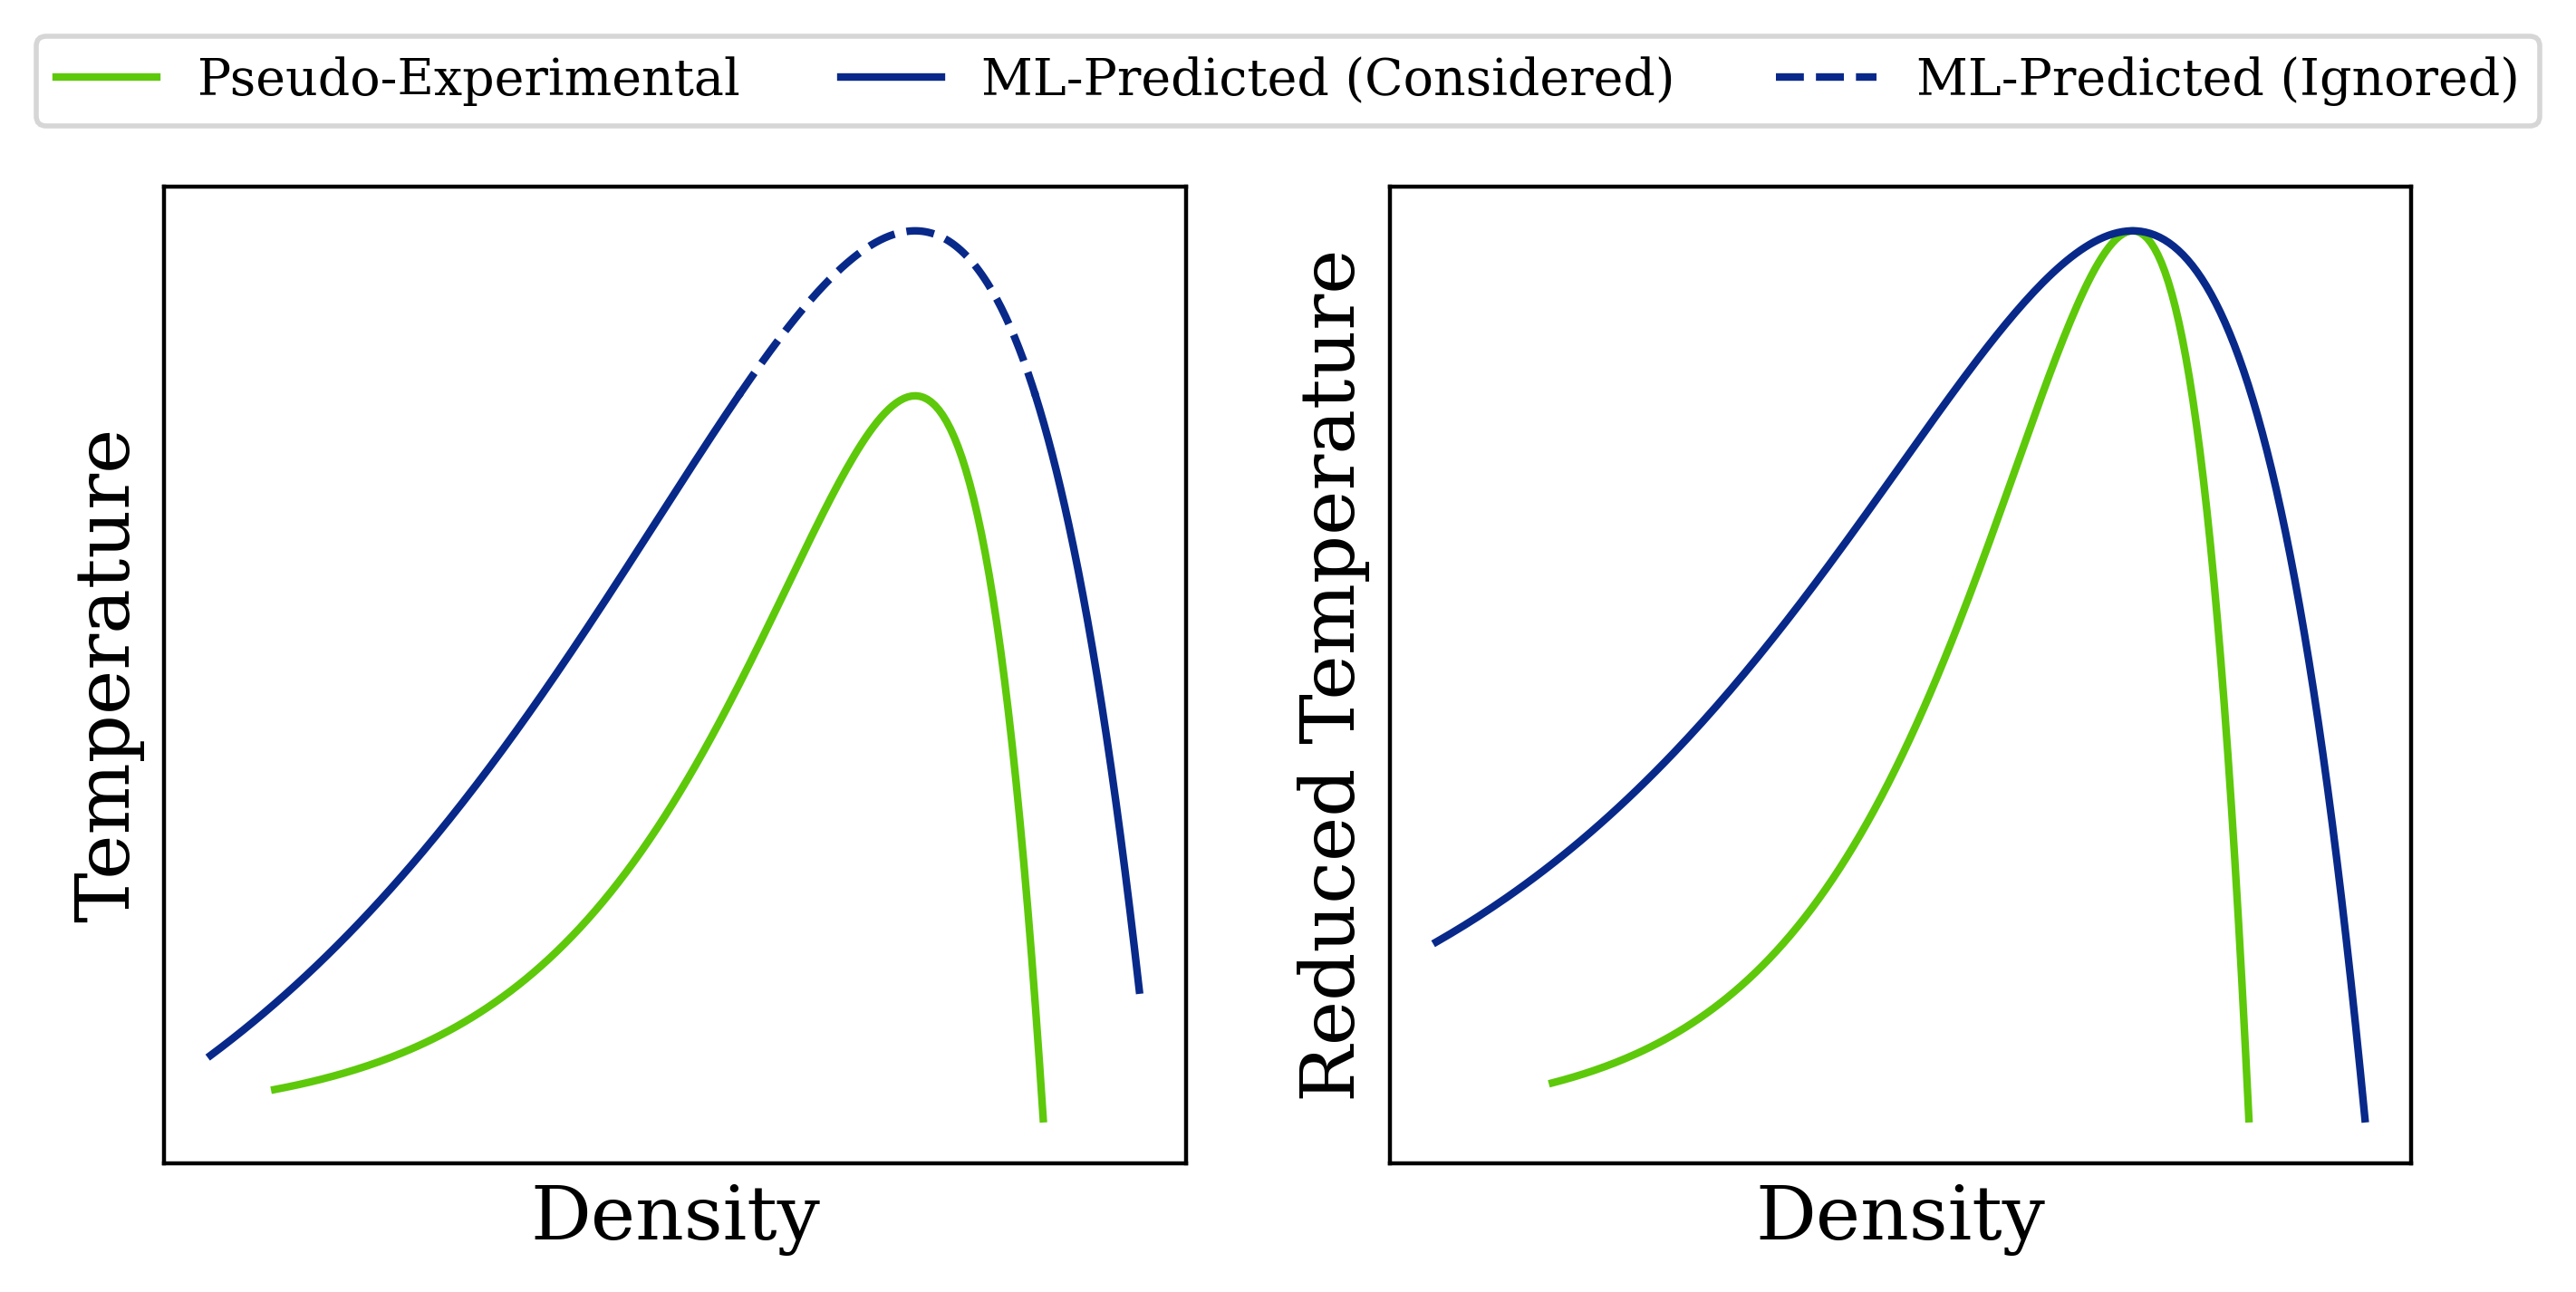

In [12]:
# Reduced temperature diagram

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif")

x1 = collect(range(4,10,200))
x2 = collect(range(3,11,200))
x3A = collect(range(3.5,7.621,200))
x3B = collect(range(9.94,10.75,200))
x4 = collect(range(7.621,9.94,200))

envelope_expt = [-2*(i-10)*exp(i-10) for i in x1]
envelope_iter_red = [-2*(j/2 - 5.5)*exp(j/2 - 5.5) for j in x2]
envelope_iterA = [-3*(j/2 - 5.5)*exp(j/2 - 5.5) - 0.2 for j in x3A]
envelope_iterB = [-3*(j/2 - 5.5)*exp(j/2 - 5.5) - 0.2 for j in x3B]
envelope_iter_ignored = [-3*(j/2 - 5.5)*exp(j/2 - 5.5) - 0.2 for j in x4]

figure_1, axes_1 = plt.subplots(1,2, figsize=(8, 3.5), dpi=400)

axes_1[1].plot(x1, envelope_expt, color="#5dc90a")
axes_1[1].plot(x3A, envelope_iterA, color="#08298a")
axes_1[1].plot(x4, envelope_iter_ignored, color="#08298a","--")
axes_1[1].plot(x3B, envelope_iterB, color="#08298a")

axes_1[2].plot(x1, envelope_expt, color="#5dc90a")
axes_1[2].plot(x2, envelope_iter_red, color="#08298a")

# axes_1[1].set_ylim([-0.2, 1])
# axes_1[1].set_xlim([-4, 0.5])

axes_1[1].set_xticks([])
axes_1[1].set_yticks([])

axes_1[2].set_xticks([])
axes_1[2].set_yticks([])

label_fontsize = 15

axes_1[1].set_xlabel("Density", fontsize=label_fontsize, fontfamily="serif")
axes_1[1].set_ylabel("Temperature", fontsize=label_fontsize, fontfamily="serif")

axes_1[2].set_xlabel("Density", fontsize=label_fontsize, fontfamily="serif")
axes_1[2].set_ylabel("Reduced Temperature", fontsize=label_fontsize, fontfamily="serif")

axes_1[1].legend(["Pseudo-Experimental","ML-Predicted (Considered)","ML-Predicted (Ignored)"],loc="upper left", fontsize=10,ncol=3,bbox_to_anchor=(-0.15, 1.18))

# tight_layout()

plt.savefig("Reduced_Temp_Illustration.svg")

